# Lightricks Challenge - DataHack 2018

In [15]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import scipy
import dateutil
from sklearn.model_selection import train_test_split,KFold
# from sklearn.cross_validation import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [25]:
%matplotlib inline
import seaborn as sns
sns.set()

In [16]:
path = './'
teamname = 'team_foo'
out_name = path + teamname + '_submission.csv'

In [17]:
df_usage = pd.read_csv(path + "train_usage_data.csv")

In [18]:
#Looking data format and types
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393138 entries, 0 to 393137
Data columns (total 5 columns):
id                393138 non-null int64
feature_name      393138 non-null object
usage_duration    393138 non-null float64
use_date          393138 non-null object
accepted          393138 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 12.4+ MB


The variables in dataframe "df_usage" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| feature_name | Name of feature used |
| usage_duration | Duration in seconds between feature was entered and accepted or canceled |
| use_date | Date and time when the feature was entered |
| accepted | True if the user accepted the changes by the feature and False if he did not accepted the changes |

In [19]:
df_usage.head()

,id,feature_name,usage_duration,use_date,accepted
0,420000380263334,Prism,4.233,2018-04-27 16:19:50,False
1,370000259367972,Darkroom,7.071,2018-04-22 10:11:05,False
2,550000326477715,Darkroom,37.881,2018-04-30 09:50:29,False
3,440000406578453,Prism,17.580,2018-04-02 00:25:46,False
4,150000389301639,Eyes,1.620,2018-04-20 16:39:48,False


In [20]:
df_users = pd.read_csv(path + "train_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'])

In [21]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8311 entries, 0 to 8310
Data columns (total 7 columns):
Unnamed: 0           8311 non-null int64
id                   8311 non-null int64
installation_date    8311 non-null datetime64[ns]
subscripiton_date    8311 non-null datetime64[ns]
country              8309 non-null object
days_until_churn     1970 non-null float64
churned              8311 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 454.6+ KB


In [22]:
df_users.head()

,Unnamed: 0,id,installation_date,subscripiton_date,country,days_until_churn,churned
0,1,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,NaN,0
1,2,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,NaN,0
2,3,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,NaN,0
3,4,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,NaN,0
4,5,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,9.0,1


The variables in dataframe "df_users" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| installation_date | Date and time when the application was first installed |
| subscription_date | Date and time when the user joined as a subscriber |
| country | Country where the user is based |
| days_until_churned | Days before the user decided to leave the subscription (churn). NaN if the user has not churned |
| churned | False if the user is still a subscriber and True if the user stopped his subscription. |

In [23]:
df_users = df_users.drop(columns='Unnamed: 0')
df_users.head()

,id,installation_date,subscripiton_date,country,days_until_churn,churned
0,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,NaN,0
1,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,NaN,0
2,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,NaN,0
3,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,NaN,0
4,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,9.0,1


# Data exploration:

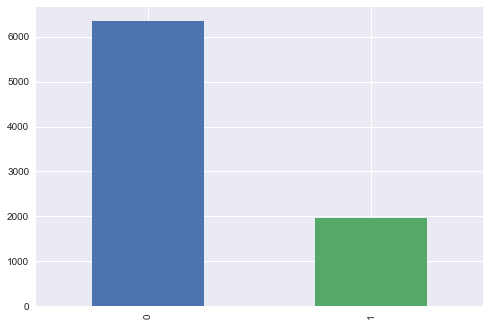

In [26]:
df_users['churned'].value_counts().plot('bar')

In [27]:
joined_df = df_usage.join(df_users.set_index('id'),on='id')

In [28]:
joined_df.head()

,id,feature_name,usage_duration,use_date,accepted,installation_date,subscripiton_date,country,days_until_churn,churned
0,420000380263334,Prism,4.233,2018-04-27 16:19:50,False,2018-04-27 16:07:01,2018-04-27 16:14:42,United States,NaN,0
1,370000259367972,Darkroom,7.071,2018-04-22 10:11:05,False,2018-04-04 20:08:02,2018-04-05 07:13:01,United Kingdom,NaN,0
2,550000326477715,Darkroom,37.881,2018-04-30 09:50:29,False,2018-04-27 08:11:24,2018-04-30 09:47:27,Greece,NaN,0
3,440000406578453,Prism,17.580,2018-04-02 00:25:46,False,2018-04-01 23:08:44,2018-04-01 23:34:53,United States,NaN,0
4,150000389301639,Eyes,1.620,2018-04-20 16:39:48,False,2017-03-14 03:52:36,2018-04-19 16:06:58,United States,NaN,0


In [35]:
total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()
total_number_of_usage_per_feature.shape

(17,)

In [31]:
k = 10
top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]

In [36]:
top_k_features_not_churned

Index(['Filters', 'Darkroom', 'Prism', 'Reshape', 'Face', 'Defocus',
       'Backdrop', 'Paint', 'Relight', 'Eyes'],
      dtype='object')

c:\python34\lib\site-packages\seaborn\categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Most used features, churned=0')

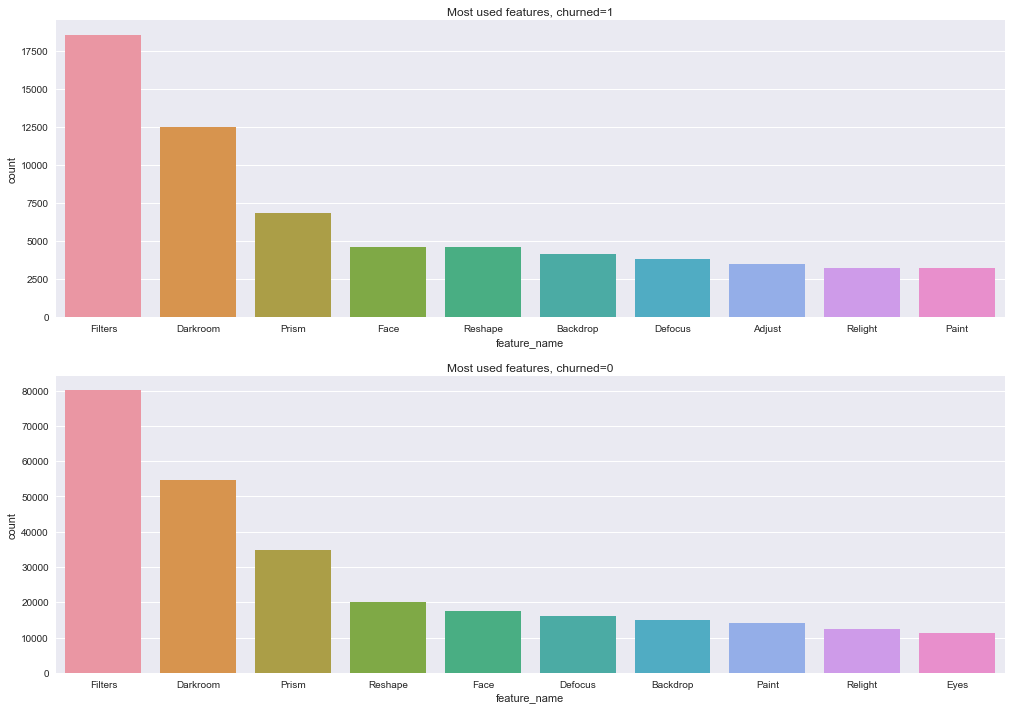

In [37]:
#What are the most popular features, within each class:

#total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()



# k = 10
# top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
# top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]


fig, ax = plt.subplots(2,1, figsize=(17,12))
df_churned = joined_df[joined_df['churned']==True]
p = sns.countplot(data=df_churned[df_churned['feature_name'].isin(top_k_features_churned)], x='feature_name', order = top_k_features_churned, ax=ax[0])

df_not_churned = joined_df[joined_df['churned']==False]
q = sns.countplot(data=df_not_churned[df_not_churned['feature_name'].isin(top_k_features_not_churned)], x='feature_name', order = top_k_features_not_churned, ax=ax[1])

ax[0].set_title('Most used features, churned=1')
ax[1].set_title('Most used features, churned=0')

In [43]:
groupedDf = joined_df.groupby(['id', 'churned'])
groupedDf.mean().head()

,,usage_duration,accepted,days_until_churn
id,churned,,,
20000443246052,0,25.288622,0.662791,NaN
20000443252617,0,30.989344,0.406250,NaN
20000443310150,0,87.370613,0.290323,NaN
20000443367561,0,280.919000,1.000000,NaN
20000443405819,0,97.946688,0.343750,NaN


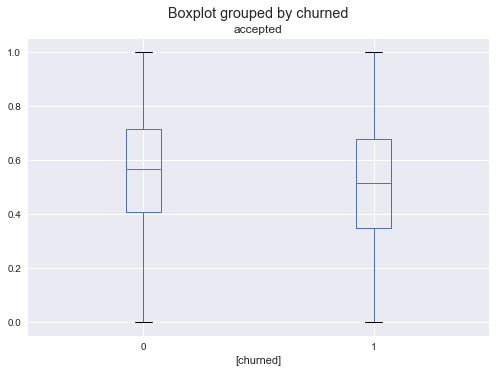

In [38]:
joined_df.groupby(['id', 'churned'])[['accepted']].mean().boxplot(by='churned')

# Creating our input data:

In [44]:
#Let's create a table with statistic summaries: rows correspond to users; columns to various statistics:
users_usage_summaries = pd.pivot_table(df_usage[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)

#Let's add the mean of 'accepted' for each user:
accepted_rate = df_usage.groupby(['id'])['accepted'].mean().to_frame()
churned = joined_df.groupby(['id'])['churned'].mean().to_frame()
users_usage_summaries = users_usage_summaries.join(accepted_rate, how='left').join(churned, how='left')

#This is how our df looks like:
users_usage_summaries.head(10)


,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette,accepted,churned
id,,,,,,,,,,,,,,,,,,,
20000443246052,9,3,4,26,11,2,6,46,3,2,0,23,4,19,8,2,4,0.662791,0
20000443252617,1,10,2,17,3,0,7,16,2,0,0,0,2,4,0,0,0,0.406250,0
20000443310150,1,3,0,3,0,3,9,3,0,0,0,0,2,6,0,1,0,0.290323,0
20000443367561,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0
20000443405819,2,0,0,4,2,0,2,9,1,2,0,6,1,2,0,1,0,0.343750,0
20000443434193,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0.750000,0
20000443469779,5,2,13,35,20,9,4,17,11,4,0,14,15,21,9,6,1,0.672043,0
20000443895994,1,15,0,43,9,0,0,29,0,0,0,2,0,5,0,2,1,0.532710,0
20000443935569,7,0,0,1,2,1,2,4,1,3,0,1,2,2,2,1,2,0.387097,1


In [45]:
users_usage_summaries.Darkroom.mean()

8.08434604740705

# Learn a decision tree:

In [47]:
X = users_usage_summaries.iloc[:, users_usage_summaries.columns!='churned'].values
y = users_usage_summaries.loc[:,'churned'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)

In [48]:
tree.DecisionTreeClassifier?

In [49]:
algo=tree.DecisionTreeClassifier(max_features=4)

train = algo.fit(X_train, y_train)
res=train.predict(X_val)

In [54]:
#Let's check the confusion matrix:
cm = metrics.confusion_matrix(y_val, res)
print(cm)
print(classification_report(y_pred=res,y_true=y_val))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res,y_true=y_val),3))

[[256  75]
 [ 67  18]]
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       331
           1       0.19      0.21      0.20        85

   micro avg       0.66      0.66      0.66       416
   macro avg       0.49      0.49      0.49       416
weighted avg       0.67      0.66      0.66       416

0.202


In [34]:
#test your predictor:

#1.Prepare your test-set (in case you created new features/transformed the input data):
df_usage_test = pd.read_csv("test_usage_data.csv")
users_usage_summaries_test = pd.pivot_table(df_usage_test[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)

accepted_rate_test = df_usage_test.groupby(['id'])['accepted'].mean().to_frame()

#Let's merge the two:
users_usage_summaries_test = users_usage_summaries_test.join(accepted_rate_test, how='left')
X_test = users_usage_summaries_test.values

In [35]:
users_usage_summaries

,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette,accepted,churned
id,,,,,,,,,,,,,,,,,,,
20000443246052,9,3,4,26,11,2,6,46,3,2,0,23,4,19,8,2,4,0.662791,0
20000443252617,1,10,2,17,3,0,7,16,2,0,0,0,2,4,0,0,0,0.406250,0
20000443310150,1,3,0,3,0,3,9,3,0,0,0,0,2,6,0,1,0,0.290323,0
20000443367561,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0
20000443405819,2,0,0,4,2,0,2,9,1,2,0,6,1,2,0,1,0,0.343750,0
20000443434193,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0.750000,0
20000443469779,5,2,13,35,20,9,4,17,11,4,0,14,15,21,9,6,1,0.672043,0
20000443895994,1,15,0,43,9,0,0,29,0,0,0,2,0,5,0,2,1,0.532710,0
20000443935569,7,0,0,1,2,1,2,4,1,3,0,1,2,2,2,1,2,0.387097,1


In [36]:
#submit result:
pred = train.predict(X_test)
df = pd.DataFrame(pred, index=users_usage_summaries_test.index.astype(str), columns=['churned'], dtype=str)
df.to_csv(out_name, header=True, quoting=csv.QUOTE_NONNUMERIC) 